In [1]:
import pandas as pd
import numpy as np
from preprocessing import preprocess
import h5py
import urllib.request
import re
from maayanlab_bioinformatics.harmonization import ncbi_genes
from get_symbol import get_symbol
from prediction_pipeline import *
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pickle as pk

/opt/apps/rhel7/Python-GPU-3.6.5/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
f = pd.read_csv('GSE156063_swab_gene_counts.csv.gz')
f.index = f.iloc[:, 0]
f = f.iloc[:, 1:]

In [4]:
f

,RR057e_00202,RR057e_00080,RR057e_00287,RR057e_00753,RR057e_00751,RR057e_00520,RR057e_00505,RR057i_00083,RR057e_00764,RR057e_00451,...,RR057i_00136,RR057i_00137,RR057i_00156,RR057i_00158,RR057e_00719,RR057e_00721,RR057e_00731,RR057e_00728,RR057i_00067,RR057i_00116
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,1534,621,1903,2796,416,15,263,834,58,177,...,264,53,578,626,134,1,56,99,297,83
ENSG00000000419,153,123,221,344,112,20,45,116,26,46,...,83,97,110,132,57,15,19,1,33,19
ENSG00000000457,295,185,457,626,170,79,164,174,57,95,...,105,170,129,128,66,36,26,31,121,61
ENSG00000000460,75,108,292,367,49,31,37,57,44,35,...,21,117,44,68,27,9,1,0,24,60
ENSG00000000938,19,471,1843,284,38,539,495,9,1528,1409,...,139,87,49,133,62,4,3,1,14,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000287856,40,77,189,62,95,156,61,23,24,70,...,7,72,14,25,5,0,9,0,7,6
ENSG00000288258,0,21,2,41,34,0,5,7,5,0,...,8,3,0,3,0,0,0,2,2,5
ENSG00000288380,34,0,0,5,0,3,3,1,11,0,...,0,0,0,0,17,8,0,1,11,2


In [5]:
norm = preprocess(f)

In [6]:
norm.shape

(15979, 234)

In [4]:
cor = np.corrcoef(norm)

In [5]:
cor = pd.DataFrame(cor, index=f.index, columns=f.index)

# Saving info

In [24]:
gene_list = (pd.DataFrame(f.index)).values.astype("S").tolist()

In [21]:
h = h5py.File('correlation.h5', 'w')

In [25]:
h.create_dataset("cor", data=cor)
h.create_dataset("genes", data=gene_list)

<HDF5 dataset "genes": shape (15979, 1), type "|S15">

In [28]:
h.close()

# Gene set libraries

In [6]:
libraries = ['GO_Biological_Process_2018', 'GO_Molecular_Function_2018', 'GO_Cellular_Component_2018']

In [7]:
cor = get_symbol(cor)

In [8]:
prediction_pipeline("correlation.h5", libraries, cor)

In [9]:
f = h5py.File("correlation.h5", "r")

In [10]:
list(f.keys())

['cor',
 'cor_GO_Biological_Process_2018',
 'cor_GO_Cellular_Component_2018',
 'cor_GO_Molecular_Function_2018',
 'genes',
 'genes_GO_Biological_Process_2018',
 'genes_GO_Cellular_Component_2018',
 'genes_GO_Molecular_Function_2018',
 'pathways_GO_Biological_Process_2018',
 'pathways_GO_Cellular_Component_2018',
 'pathways_GO_Molecular_Function_2018']

# SVD

In [32]:
f = h5py.File("correlation.h5", "r+")

In [13]:
list(f.keys())

['cor',
 'cor_GO_Biological_Process_2018',
 'cor_GO_Cellular_Component_2018',
 'cor_GO_Molecular_Function_2018',
 'genes',
 'genes_GO_Biological_Process_2018',
 'genes_GO_Cellular_Component_2018',
 'genes_GO_Molecular_Function_2018',
 'pathways_GO_Biological_Process_2018',
 'pathways_GO_Cellular_Component_2018',
 'pathways_GO_Molecular_Function_2018',
 'svd_cor_GO_Biological_Process_2018',
 'svd_cor_GO_Cellular_Component_2018',
 'svd_cor_GO_Molecular_Function_2018']

In [14]:
cor = [ c for c in list(f.keys()) if "cor_" in c ]
cor

['cor_GO_Biological_Process_2018',
 'cor_GO_Cellular_Component_2018',
 'cor_GO_Molecular_Function_2018',
 'svd_cor_GO_Biological_Process_2018',
 'svd_cor_GO_Cellular_Component_2018',
 'svd_cor_GO_Molecular_Function_2018']

In [26]:
for c in cor:
    svd = np.linalg.svd(pd.DataFrame(f[c]).fillna(0))[1]
    f.create_dataset("svd_" + c, data=svd)
    print(c)
print(list(f.keys()))
f.close()

cor_GO_Biological_Process_2018
cor_GO_Cellular_Component_2018
cor_GO_Molecular_Function_2018
['cor', 'cor_GO_Biological_Process_2018', 'cor_GO_Cellular_Component_2018', 'cor_GO_Molecular_Function_2018', 'genes', 'genes_GO_Biological_Process_2018', 'genes_GO_Cellular_Component_2018', 'genes_GO_Molecular_Function_2018', 'pathways_GO_Biological_Process_2018', 'pathways_GO_Cellular_Component_2018', 'pathways_GO_Molecular_Function_2018', 'svd_cor_GO_Biological_Process_2018', 'svd_cor_GO_Cellular_Component_2018', 'svd_cor_GO_Molecular_Function_2018']


# PCA

In [50]:
def pca_function(data_name):
    data = pd.DataFrame(f[data_name]).dropna(axis=1)
#     define transform
    pca = PCA()
    transformed = pca.fit_transform(data)
    pk.dump(pca, open("pca.pkl","wb"))
    var = pca.explained_variance_
    f.create_dataset("pca_" + data_name, data=transformed)
    f.create_dataset("var_" + data_name, data=var)

In [30]:
for c in cor:
    pca_function(c)
    print(c)
print(list(f.keys()))
f.close()

cor_GO_Biological_Process_2018
cor_GO_Cellular_Component_2018
cor_GO_Molecular_Function_2018
svd_cor_GO_Biological_Process_2018
svd_cor_GO_Cellular_Component_2018
svd_cor_GO_Molecular_Function_2018
['cor', 'cor_GO_Biological_Process_2018', 'cor_GO_Cellular_Component_2018', 'cor_GO_Molecular_Function_2018', 'genes', 'genes_GO_Biological_Process_2018', 'genes_GO_Cellular_Component_2018', 'genes_GO_Molecular_Function_2018', 'pathways_GO_Biological_Process_2018', 'pathways_GO_Cellular_Component_2018', 'pathways_GO_Molecular_Function_2018', 'pca_cor_GO_Biological_Process_2018', 'pca_cor_GO_Cellular_Component_2018', 'pca_cor_GO_Molecular_Function_2018', 'pca_svd_cor_GO_Biological_Process_2018', 'pca_svd_cor_GO_Cellular_Component_2018', 'pca_svd_cor_GO_Molecular_Function_2018', 'svd_cor_GO_Biological_Process_2018', 'svd_cor_GO_Cellular_Component_2018', 'svd_cor_GO_Molecular_Function_2018', 'var_cor_GO_Biological_Process_2018', 'var_cor_GO_Cellular_Component_2018', 'var_cor_GO_Molecular_Functi

In [36]:
var = [v for v in list(f.keys()) if "var" in v]
var

['var_cor_GO_Biological_Process_2018',
 'var_cor_GO_Cellular_Component_2018',
 'var_cor_GO_Molecular_Function_2018']

In [42]:
np.array(f[var[1]])

array([2.73979903e+05, 5.17656802e+03, 1.38857629e+03, ...,
       8.74589198e-28, 5.34718400e-28, 4.31400868e-29])

In [52]:
X = pd.DataFrame(f[cor[0]]).dropna(axis=1)

In [76]:
pca = PCA(n_components=2)
pca.fit(X)
transformed = pca.transform(X)

In [77]:
print("original shape:   ", X.shape)
print("transformed shape:", transformed.shape)

original shape:    (14433, 11668)
transformed shape: (14433, 2)


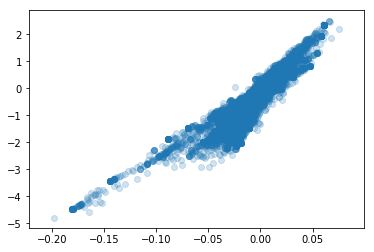

In [78]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->', linewidth=2, shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X.iloc[:,0], X.iloc[:, 1], alpha=0.2)

array([-0.06918196, -2.46963451,  0.0844749 , ..., -5.01654175,
        5.45955073, -1.10706653])

array([-0.00420723, -0.27019205,  0.02149127, ..., -0.92924467,
        0.84924658, -0.02481491])

array([-0.07338919, -2.73982656,  0.10596617, ..., -5.94578642,
        6.30879731, -1.13188144])

ValueError: too many values to unpack (expected 2)

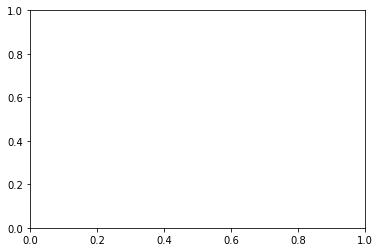

In [84]:
mean = pca.mean_
for length, vector in zip(pca.explained_variance_, pca.components_): 
    v = vector * 3 * np.sqrt(length)
    display(mean)
    display(mean + v)
    draw_vector(pca.mean_, pca.mean_ + v)
    break

ValueError: too many values to unpack (expected 2)

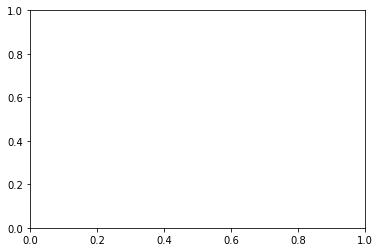

In [80]:
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

In [ ]:
pca.fit(X)

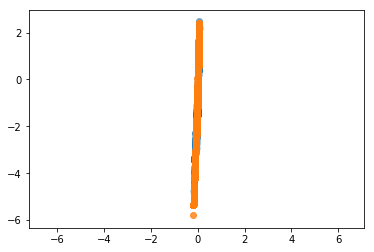

In [91]:
X_new = pca.inverse_transform(transformed)
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');

In [90]:
X

,1,2,3,4,6,8,9,10,11,12,...,14423,14424,14425,14426,14427,14428,14429,14430,14431,14432
0,-0.026378,-1.268975,0.107865,-0.729151,0.239219,0.129384,-0.186801,-0.081057,0.115797,0.052232,...,1.652544,-0.125248,2.050016,0.226479,0.913643,0.010155,0.002252,-4.352432,3.409001,0.033780
1,0.046137,1.687342,0.083065,1.817246,-0.824386,-0.058963,0.166096,2.391429,2.641028,0.056202,...,-7.444400,-0.221104,-1.167337,-0.218039,0.188250,-0.033224,-0.000244,1.220236,-2.566008,1.824799
2,-0.001024,0.006610,0.008240,-0.144488,-0.048023,0.004488,0.069955,0.012086,0.029617,0.000121,...,0.105446,0.004993,0.216003,0.003679,0.059870,0.001321,-0.000319,-0.071364,0.081608,0.019808
3,0.015944,0.101413,-0.002243,0.676540,0.155809,0.017785,-0.628749,0.192068,0.202036,0.027124,...,-0.923169,-0.041608,-0.566061,-0.006483,-0.089408,-0.005455,0.004160,-0.502630,-0.083206,0.085666
4,0.000307,0.084698,-0.000366,0.319137,-0.004283,-0.008486,0.044616,0.079683,0.130853,-0.000126,...,-0.356479,-0.005019,-0.099637,-0.009094,-0.015467,-0.001108,-0.001386,0.228884,-0.187998,0.061207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14428,-0.028604,-1.588837,0.105305,-1.252797,0.080897,0.135439,0.182210,-0.140348,-0.190875,0.053625,...,2.375231,-0.084090,1.808776,0.284865,1.015143,0.024211,0.011587,-4.141030,4.205864,-0.210444
14429,-0.028604,-1.588837,0.105305,-1.252797,0.080897,0.135439,0.182210,-0.140348,-0.190875,0.053625,...,2.375231,-0.084090,1.808776,0.284865,1.015143,0.024211,0.011587,-4.141030,4.205864,-0.210444
14430,-0.007097,-0.151544,0.011115,-0.150029,0.006877,0.006070,0.213231,-0.087530,-0.048048,-0.003264,...,0.382890,0.000518,0.410299,0.019297,0.090497,0.002318,-0.000613,0.148545,0.551951,-0.011019
14431,-0.007097,-0.151544,0.011115,-0.150029,0.006877,0.006070,0.213231,-0.087530,-0.048048,-0.003264,...,0.382890,0.000518,0.410299,0.019297,0.090497,0.002318,-0.000613,0.148545,0.551951,-0.011019
